In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler,MinMaxScaler, PolynomialFeatures,PowerTransformer
from sklearn.metrics import roc_auc_score,precision_score,recall_score,accuracy_score
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier

from sklearn.decomposition import PCA

In [2]:
df=pd.read_csv("data/train.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101763 entries, 0 to 101762
Data columns (total 23 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   id                 101763 non-null  int64  
 1   loc                101763 non-null  float64
 2   v(g)               101763 non-null  float64
 3   ev(g)              101763 non-null  float64
 4   iv(g)              101763 non-null  float64
 5   n                  101763 non-null  float64
 6   v                  101763 non-null  float64
 7   l                  101763 non-null  float64
 8   d                  101763 non-null  float64
 9   i                  101763 non-null  float64
 10  e                  101763 non-null  float64
 11  b                  101763 non-null  float64
 12  t                  101763 non-null  float64
 13  lOCode             101763 non-null  int64  
 14  lOComment          101763 non-null  int64  
 15  lOBlank            101763 non-null  int64  
 16  lo

<Axes: >

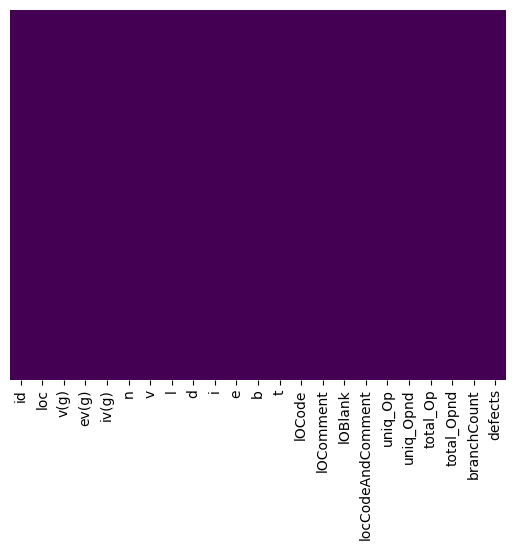

In [3]:
na_count=[]
for column in df.columns:
    na_count.append((column,np.count_nonzero(df[column].isnull())))
na_count.sort(key=lambda x:x[1],reverse=True)
for i in na_count:
    if i[1]==0:break
    print(i[0],'     ',i[1])

sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis')

<Axes: >

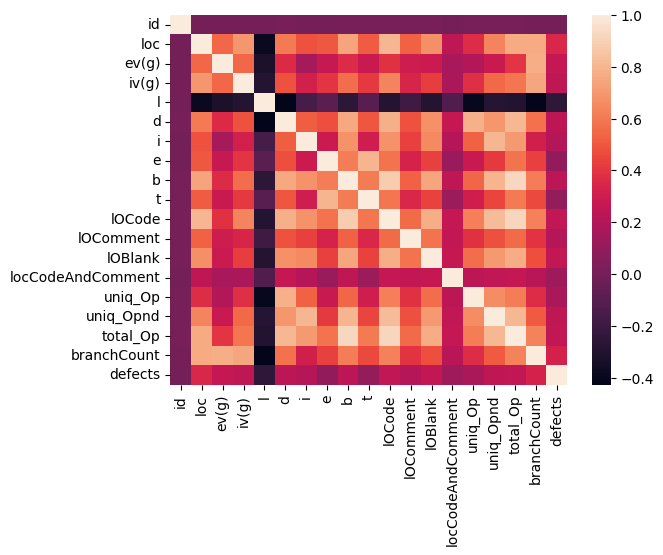

In [4]:
sns.heatmap(df.drop(columns=['v(g)','n','v','total_Opnd']).corr())

In [5]:
df=pd.read_csv("data/train.csv")

In [6]:
df=df.drop(columns=['v(g)','n','v','total_Opnd'])

In [7]:
y=df['defects'].astype('int')
x=df.drop(columns=['defects','id'])
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.3,stratify=y)

Len: 101763
1label count: 23064 0.23
0label count: 78699 0.77


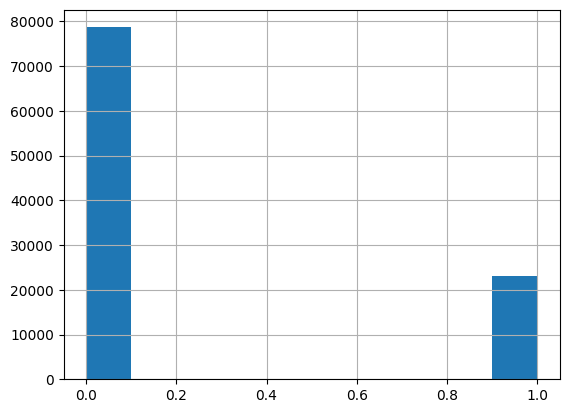

In [8]:
y.hist()
print('Len:', len(y))
print('1label count:',np.count_nonzero(y), np.round(np.count_nonzero(y)/len(y),2))
print('0label count:',len(y)-np.count_nonzero(y),np.round((len(y)-np.count_nonzero(y))/len(y),2))

In [9]:
indices_to_add = []
indexes=y_train[y_train==1].index
for i in range(55089-16145):
    indices_to_add.append(indexes[random.randint(0,len(indexes)-1)])
X_train_to_add = x_train.loc[indices_to_add]
y_train_to_add = pd.DataFrame(y_train.loc[indices_to_add],columns=['defects'])

In [10]:
x_train = pd.concat((x_train, X_train_to_add))
y_train = pd.concat((pd.DataFrame(y_train), y_train_to_add))

Len: 110178
1label count: 55089 0.5
0label count: 55089 0.5


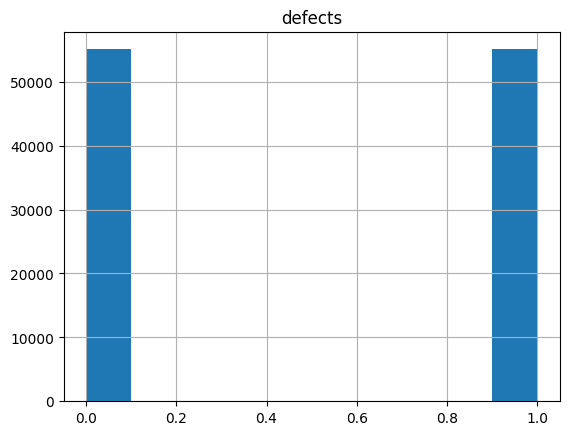

In [11]:
y_train.hist()
print('Len:', len(y_train))
print('1label count:',np.count_nonzero(y_train), np.round(np.count_nonzero(y_train)/len(y_train),2))
print('0label count:',len(y_train)-np.count_nonzero(y_train),np.round((len(y_train)-np.count_nonzero(y_train))/len(y_train),2))

In [12]:
def fit_test(estimaror:LogisticRegression, param_grid,x_train,y_train,x_test,y_test:StandardScaler,cv=3):

    estimator=GridSearchCV(estimator=estimaror,param_grid=param_grid,cv=cv)
    estimator.fit(x_train, y_train)
    
    y_pred_train=estimator.predict(x_train.values)
    accuracy_train=accuracy_score(y_train, y_pred_train)
    precision_train=precision_score(y_train, y_pred_train)
    recall_train=recall_score(y_train, y_pred_train)
    roc_auc_train=roc_auc_score(y_train, estimator.predict_proba(x_train.values)[:, 1])

    y_pred=estimator.predict(x_test.values)
    accuracy_test=accuracy_score(y_test, y_pred)
    precision_test=precision_score(y_test, y_pred)
    recall_test=recall_score(y_test, y_pred)
    roc_auc_test=roc_auc_score(y_test, estimator.predict_proba(x_test.values)[:, 1])

    print('Best params:', estimator.best_params_)
    print('---------------------------')
    print('Train accuracy:', accuracy_train)
    print('Train precision:', precision_train)
    print('Train recall:', recall_train)
    print('Train rocauc:', roc_auc_train)
    print('---------------------------')
    print('Test accuracy:', accuracy_test)
    print('Test precision:', precision_test)
    print('Test recall:', recall_test)
    print('Test rocauc:', roc_auc_test)
    return estimator, y_pred


In [27]:
#read
df=pd.read_csv("data/train.csv")


# high corr columns drop
# df=df.drop(columns=['v(g)','n','v','total_Opnd'])


#oversampling
y=df['defects'].astype('int')
x=df.drop(columns=['defects','id'])
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.3,stratify=y)

indices_to_add = []
indexes=y_train[y_train==1].index
for i in range(55089-16145):
    indices_to_add.append(indexes[random.randint(0,len(indexes)-1)])
X_train_to_add = x_train.loc[indices_to_add]
y_train_to_add = pd.DataFrame(y_train.loc[indices_to_add],columns=['defects'])

x_train = pd.concat((x_train, X_train_to_add))
y_train = pd.concat((pd.DataFrame(y_train), y_train_to_add))

x_train.index=range(len(x_train))
y_train.index=range(len(y_train))



#poly
# poly=PolynomialFeatures()
# x_train=pd.DataFrame(poly.fit_transform(x_train))
# x_test=pd.DataFrame(poly.transform(x_test))



# Scaling
# x_scaler=MinMaxScaler()
# x_train=pd.DataFrame(x_scaler.fit_transform(x_train),columns=x_train.columns)
# x_test=pd.DataFrame(x_scaler.transform(x_test),columns=x_test.columns)



pt = PowerTransformer(method='yeo-johnson')
x_train=pd.DataFrame(pt.fit_transform(x_train),columns=x_train.columns)
x_test=pd.DataFrame(pt.transform(x_test),columns=x_train.columns)

# PCA
# pca=PCA(10)
# x_train=pd.DataFrame(pca.fit_transform(x_train))
# x_test=pd.DataFrame(pca.transform(x_test))

<Axes: >

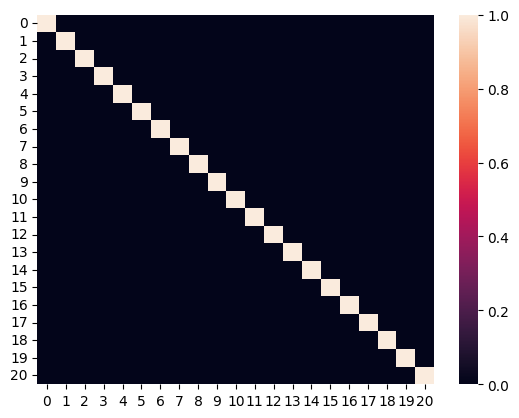

In [18]:
sns.heatmap(x_train.corr())

In [22]:
x_train.describe()

,0,1,2,3,4,5,6,7,8,9
count,1.101780e+05,1.101780e+05,1.101780e+05,1.101780e+05,1.101780e+05,1.101780e+05,1.101780e+05,1.101780e+05,1.101780e+05,1.101780e+05
mean,3.714649e-17,-8.254776e-17,-4.959315e-17,2.012102e-17,-3.301910e-17,7.093948e-18,-2.966560e-17,1.734793e-17,-5.740455e-17,-5.159235e-18
std,3.668431e+00,2.025995e+00,9.502621e-01,8.037632e-01,7.351053e-01,6.357145e-01,5.661826e-01,4.449052e-01,3.909361e-01,3.128777e-01
min,-7.309690e+00,-5.206320e+00,-2.838046e+00,-2.753839e+00,-2.344918e+00,-3.645138e+00,-5.121553e+00,-3.404087e+00,-2.200771e+00,-3.176417e+00
25%,-2.689064e+00,-1.409407e+00,-5.142123e-01,-5.090388e-01,-5.138150e-01,-3.860853e-01,-3.226435e-01,-2.987105e-01,-2.472489e-01,-1.423255e-01
50%,-2.339210e-01,-3.897248e-01,-1.669745e-01,1.401940e-01,2.099295e-02,4.071119e-02,2.931203e-02,-2.410804e-02,-6.213102e-02,1.133773e-02
75%,2.457853e+00,9.175493e-01,1.080070e-01,4.420329e-01,4.686122e-01,4.069607e-01,3.694498e-01,2.664904e-01,1.839615e-01,1.500623e-01
max,1.886938e+01,8.089953e+00,4.313369e+00,4.190296e+00,3.024361e+00,4.706031e+00,7.207335e+00,3.846828e+00,3.042421e+00,1.318033e+01


In [24]:
sum(pca.explained_variance_ratio_)

0.9916487257486587

In [129]:
obs=pd.concat((x_train,y_train), axis=1)
y_1=obs[obs['defects']==1]
y_0=obs[obs['defects']==0]

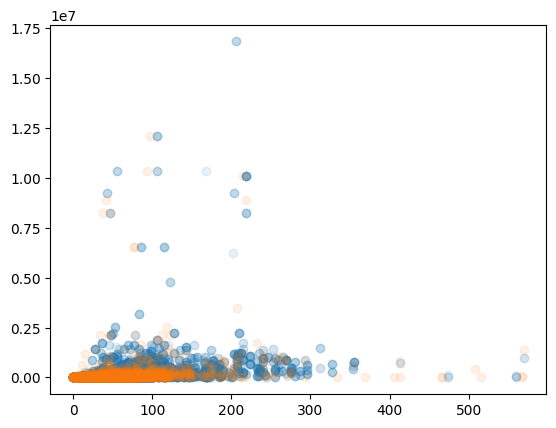

In [132]:
plt.scatter(y_1['i'],y_1['e'],alpha=0.1)
plt.scatter(y_0['i'],y_0['e'],alpha=0.1)

In [76]:
y_1.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,defects
count,55089.000000,55089.000000,55089.000000,55089.000000,55089.000000,55089.000000,55089.000000,55089.000000,55089.000000,55089.000000,55089.000000,55089.000000,55089.000000,55089.000000,55089.000000,55089.0
mean,0.041641,-0.001639,0.002129,-0.002559,0.001768,-0.000694,-0.000898,0.001175,0.000150,-0.000201,-0.000449,0.000878,0.000050,-0.000110,-0.000077,1.0
std,0.113192,0.088512,0.056887,0.035964,0.036631,0.028409,0.026789,0.023717,0.022207,0.019751,0.015429,0.011862,0.011730,0.009459,0.009086,0.0
min,-0.461537,-0.124424,-0.482738,-0.569461,-0.393390,-0.694704,-0.210638,-0.548838,-0.443999,-0.634755,-0.589729,-0.338351,-0.266043,-0.359946,-0.209741,1.0
25%,-0.000372,-0.034912,-0.024718,-0.014576,-0.008284,-0.011792,-0.010443,-0.004929,-0.005613,-0.005484,-0.003501,-0.002629,-0.001935,-0.002856,-0.000684,1.0
50%,0.036120,-0.011903,-0.007979,-0.000011,-0.004664,0.000412,0.000549,0.000149,-0.000716,0.001196,0.000655,0.000006,0.000074,-0.000127,0.000080,1.0
75%,0.081764,0.020939,0.017800,0.010614,-0.000588,0.010453,0.007013,0.006248,0.003614,0.005680,0.003846,0.003539,0.002075,0.002662,0.000736,1.0
max,1.703920,1.458815,1.166406,0.707714,0.926504,0.773993,0.653876,0.873297,0.539129,0.762928,0.686315,0.287119,0.729337,0.314886,0.801964,1.0


In [33]:
y_0.describe()

,0,defects
count,55089.000000,55089.0
mean,-0.085182,0.0
std,0.389791,0.0
min,-0.124902,0.0
25%,-0.122897,0.0
50%,-0.118326,0.0
75%,-0.100082,0.0
max,44.563216,0.0


In [36]:
import scipy.stats as stats

In [86]:
stats.normaltest(y_1[0])

NormaltestResult(statistic=27369.540332010474, pvalue=0.0)

In [30]:
print('L2 LogisticRegression')
params={
    'random_state':[0],
    'fit_intercept':[True],
    'class_weight':['balanced'],
    'penalty':['l2'],
    'C':np.linspace(0,1,10)
}

estimator,y_pred=fit_test(estimaror=LogisticRegression(),
         param_grid=params,
         x_train=x_train,
         y_train=y_train,
         x_test=x_test,
         y_test=y_test
       )

L2 LogisticRegression


c:\Python\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Python\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Python\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

Best params: {'C': 0.1111111111111111, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l2', 'random_state': 0}
---------------------------
Train accuracy: 0.719617346475703
Train precision: 0.733386060687899
Train recall: 0.6901196246074534
Train rocauc: 0.7858557176071032
---------------------------
Test accuracy: 0.7390677716269777
Test precision: 0.4510518934081346
Test recall: 0.6972105795635207
Test rocauc: 0.788655745961972


c:\Python\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Python\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
c:\Python\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
c:\Python\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.

In [31]:
coefs=pd.DataFrame(estimator.best_estimator_.coef_[0], x_train.columns, columns=["coef"]).sort_values(by="coef", ascending=False)
coefs

,coef
b,1.330842
loc,1.247076
e,0.714129
l,0.434266
n,0.407757
d,0.276121
lOBlank,0.166338
uniq_Op,0.145705
v(g),0.129436
uniq_Opnd,0.088975


In [28]:
print('L1 LogisticRegression')
params={
    'random_state':[0],
    'fit_intercept':[True],
    'class_weight':['balanced'],
    'penalty':['l1'],
    'solver':['liblinear'],
    'C':[10],#np.linspace(0.1,10,10)
}


estimator,y_pred=fit_test(estimaror=LogisticRegression(),
         param_grid=params,
         x_train=x_train,
         y_train=y_train,
         x_test=x_test,
         y_test=y_test
       )

L1 LogisticRegression


c:\Python\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Python\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Python\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Python\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=Tr

Best params: {'C': 10, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'random_state': 0, 'solver': 'liblinear'}
---------------------------
Train accuracy: 0.7196264226978163
Train precision: 0.7339689047029703
Train recall: 0.6889760206211767
Train rocauc: 0.7858559996687173
---------------------------
Test accuracy: 0.7397228864358479
Test precision: 0.45181570798536175
Test recall: 0.6959098135568724
Test rocauc: 0.7887149963463589


In [29]:
coefs=pd.DataFrame(estimator.best_estimator_.coef_[0], x_train.columns, columns=["coef"]).sort_values(by="coef", ascending=False)
coefs

,coef
b,1.360571
loc,1.258100
e,0.907200
n,0.561727
l,0.427203
d,0.327174
lOBlank,0.167516
uniq_Op,0.152228
v(g),0.124865
uniq_Opnd,0.112645


In [ ]:
import plotly.graph_objects as go

t_array=np.arange(start=0,stop=max(abs(coefs.values))[0],step=0.002)
counts=[]
for t in t_array:
    counter=0
    for val in coefs.values: 
        if abs(val)>t:counter+=1
    counts.append(counter)


fig = go.Figure(data=go.Scatter(x=t_array, y=counts))
fig.show()

In [96]:
print('DecisionTreeClassifier')
params={
    'criterion':['entropy'],
    'random_state':[0],
    'max_depth':[20],
}


estimator,y_pred=fit_test(estimaror=DecisionTreeClassifier(),
         param_grid=params,
         x_train=x_train,
         y_train=y_train,
         x_test=x_test,
         y_test=y_test
       )

DecisionTreeClassifier
Best params: {'criterion': 'entropy', 'max_depth': 20, 'random_state': 0}
---------------------------
Train accuracy: 0.8627856740910164
Train precision: 0.8759428904648144
Train recall: 0.8452867178565594
Train rocauc: 0.943810582800251
---------------------------
Test accuracy: 0.7365128238723836
Test precision: 0.434279705573081
Test recall: 0.5372163607457725
Test rocauc: 0.656760656177653


In [207]:
from sklearn import tree

[Text(0.5, 0.8333333333333334, 'x[0] <= -0.093\nentropy = 1.0\nsamples = 110178\nvalue = [55089, 55089]'),
 Text(0.25, 0.5, 'x[0] <= -0.139\nentropy = 0.961\nsamples = 73816\nvalue = [45474, 28342]'),
 Text(0.125, 0.16666666666666666, 'entropy = 0.801\nsamples = 11831\nvalue = [2881, 8950]'),
 Text(0.375, 0.16666666666666666, 'entropy = 0.896\nsamples = 61985\nvalue = [42593, 19392]'),
 Text(0.75, 0.5, 'x[0] <= -0.036\nentropy = 0.833\nsamples = 36362\nvalue = [9615, 26747]'),
 Text(0.625, 0.16666666666666666, 'entropy = 0.961\nsamples = 14720\nvalue = [5659, 9061]'),
 Text(0.875, 0.16666666666666666, 'entropy = 0.686\nsamples = 21642\nvalue = [3956, 17686]')]

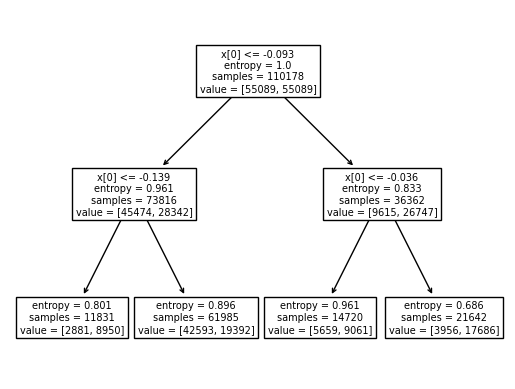

In [215]:
tree.plot_tree(estimator.best_estimator_)

In [32]:
print('RandomForestClassifier')
params={
    'criterion':['gini'],
    'random_state':[0],
    'max_depth':[10],#np.arange(10,100,10),
    'n_estimators':[150],#np.arange(10,1000,100),
    'bootstrap':[True],
    'max_features':[int(len(x_test.columns)/3)],
    'oob_score':[True]
}


estimator,y_pred=fit_test(estimaror=RandomForestClassifier(),
         param_grid=params,
         x_train=x_train,
         y_train=y_train,
         x_test=x_test,
         y_test=y_test
       )

RandomForestClassifier


c:\Python\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Python\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Python\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Python\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args

Best params: {'bootstrap': True, 'criterion': 'gini', 'max_depth': 10, 'max_features': 7, 'n_estimators': 150, 'oob_score': True, 'random_state': 0}
---------------------------
Train accuracy: 0.7664597288024833
Train precision: 0.7939798125450613
Train recall: 0.7196536513641562
Train rocauc: 0.8392258204001848
---------------------------
Test accuracy: 0.7632087523338466
Test precision: 0.4835944115156647
Test recall: 0.6603555427084838
Test rocauc: 0.7928148976732579


In [36]:
print('XGBClassifier')
params={
    'objective':['binary:logistic'], 
    'n_estimators':[100],
    'learning_rate':[0.1],
    'colsample_bylevel':[1],
    'colsample_bytree':[1],
    'max_depth':[3],
    'n_jobs':[3],
}

estimator,y_pred=fit_test(estimaror=XGBClassifier(),
         param_grid=params,
         x_train=x_train,
         y_train=y_train,
         x_test=x_test,
         y_test=y_test
       )

XGBClassifier


c:\Python\Lib\site-packages\xgboost\data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Python\Lib\site-packages\xgboost\data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
c:\Python\Lib\site-packages\xgboost\data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
c:\Python\Lib\site-packages\xgboost\data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
c:\Python\Lib\site-packages\xgboost\data.py:345: FutureWarning: is_cate

Best params: {'colsample_bylevel': 1, 'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'n_jobs': 3, 'objective': 'binary:logistic'}
---------------------------
Train accuracy: 0.7287026448111238
Train precision: 0.7517886406331188
Train recall: 0.6828586469168073
Train rocauc: 0.797210318439519
---------------------------
Test accuracy: 0.7509253496675292
Test precision: 0.4661058881741712
Test recall: 0.6807342101459749
Test rocauc: 0.7934198313038285


In [223]:
print('SVC')
params={
    # 'C':[100],
    # 'kernel':['rbf'],
    # 'degree':[3],
    # 'class_weight':['balanced'],
    # 'tol':[0.001],
    # 'cache_size':[1],
    # 'probability':[False],
    # 'max_iter':[10],
    # 'gamma':[0.1]
}


estimator,y_pred=fit_test(estimaror=SVC(),
         param_grid=params,
         x_train=x_train,
         y_train=y_train,
         x_test=x_test,
         y_test=y_test
       )

SVC


c:\Python\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [136]:
print('LinearDiscriminantAnalysis')
params={
    'solver': ['svd'] ,
    'store_covariance': [False, True],
    'tol':[0.1]

}


estimator,y_pred=fit_test(estimaror=LinearDiscriminantAnalysis(),
         param_grid=params,
         x_train=x_train,
         y_train=y_train,
         x_test=x_test,
         y_test=y_test
       )

LinearDiscriminantAnalysis


c:\Python\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Python\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Python\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Python\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=Tr

Best params: {'solver': 'svd', 'store_covariance': False, 'tol': 0.1}
---------------------------
Train accuracy: 0.7224945088856215
Train precision: 0.7338586583225215
Train recall: 0.6981974622882972
Train rocauc: 0.7863462570231542
---------------------------
Test accuracy: 0.7311408824396476
Test precision: 0.44092034100284166
Test recall: 0.6951871657754011
Test rocauc: 0.7840438757697147


c:\Python\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LinearDiscriminantAnalysis was fitted with feature names
  warnings.warn(


In [137]:
print('KNeighborsClassifier')
params={
}


estimator,y_pred=fit_test(estimaror=KNeighborsClassifier(),
         param_grid=params,
         x_train=x_train,
         y_train=y_train,
         x_test=x_test,
         y_test=y_test
       )

KNeighborsClassifier


c:\Python\Lib\site-packages\sklearn\neighbors\_classification.py:228: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
c:\Python\Lib\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Python\Lib\site-packages\sklearn\model_selection\_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Python\Lib\site-packages\sklearn\metrics\_scorer.py", line 527, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Python\Lib\site-packages\sklearn\base.py", line 705, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
          

<h3>Creating answer</h3>

In [46]:
x_test=pd.read_csv('data/test.csv')
x_test=x_test.drop(columns=['id'])


df=pd.read_csv('data/train.csv')
y_train=df['defects'].astype('int')
x_train=df.drop(columns=['defects','id'])

indices_to_add_final = []
indexes_final=y_train[y_train==1].index
for i in range(len(y_train)-np.count_nonzero(y_train)):
    indices_to_add.append(indexes_final[random.randint(0,len(indexes_final)-1)])
X_train_to_add = x_train.loc[indices_to_add_final]
y_train_to_add = pd.DataFrame(y_train.loc[indices_to_add_final],columns=['defects'])

x_train = pd.concat((x_train, X_train_to_add))
y_train = pd.concat((pd.DataFrame(y_train), y_train_to_add))

# x_scaler=MinMaxScaler()
# x_train_oversampled_scaled_final=pd.DataFrame(x_scaler.fit_transform(x_train_oversampled_final),columns=x_train_oversampled_final.columns)
# x_test_scaled=pd.DataFrame(x_scaler.transform(x_test),columns=x_test.columns)

# poly=PolynomialFeatures()
# x_train_oversampled_scaled_final_poly=pd.DataFrame(poly.fit_transform(x_train_oversampled_scaled_final))
# x_test_scaled_poly=pd.DataFrame(poly.transform(x_test_scaled))

# pca=PCA(11)
# x_train_oversampled_scaled_final_poly_pca=pd.DataFrame(pca.fit_transform(x_train_oversampled_scaled_final_poly))
# x_test_scaled_poly_pca=pd.DataFrame(pca.transform(x_test_scaled_poly))


pt = PowerTransformer(method='yeo-johnson')
x_train=pd.DataFrame(pt.fit_transform(x_train),columns=x_train.columns)
x_test=pd.DataFrame(pt.transform(x_test),columns=x_train.columns)

In [47]:
print('XGBClassifier')
params={
    'objective':'binary:logistic', 
    'n_estimators':100,
    'learning_rate':0.1,
    'colsample_bylevel':1,
    'colsample_bytree':1,
    'max_depth':3,
    'n_jobs':3,
    'random_state':11
}

estimaror=XGBClassifier(**params)
estimaror.fit(x_train,y_train)
answer=pd.DataFrame(estimaror.predict_proba(x_test)[:,1],columns=['defects'])
answer.index=range(101763,169605)
answer.to_csv('answer.csv')

XGBClassifier


c:\Python\Lib\site-packages\xgboost\data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Python\Lib\site-packages\xgboost\data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
c:\Python\Lib\site-packages\xgboost\data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
c:\Python\Lib\site-packages\xgboost\data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
c:\Python\Lib\site-packages\xgboost\data.py:345: FutureWarning: is_cate

In [88]:
y_train_pred=estimaror.predict_proba(x_train_oversampled_scaled_final)[:,1]
roc_auc_score(y_train_oversampled_final,y_train_pred)

0.8395325816819024